In [4]:
import uproot4
import numpy as np
import numba
import awkward as ak
from scipy.stats import norm
from scipy.optimize import curve_fit
from coffea import hist
from coffea.processor import defaultdict_accumulator
import os
from scipy.stats import binned_statistic
import copy

import optparse
import importlib
import pathlib

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import mplhep as hep
plt.style.use(hep.style.DQ)

#Just to efficiently save plots
plot_dir = "plot/"
from datetime import datetime
now = datetime.now()
dt_string = now.strftime("%d-%m-%Y")
save_path = plot_dir + dt_string

print("Saving plots to: ", save_path)

#Plot settings
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'small',
         'axes.labelsize': 'large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium'}
pylab.rcParams.update(params)

#line thickness
import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 5

## Data processing codes
# Process Data
def getData(fname="", treeName="Events"):
    dq_dict_ak1 = uproot4.lazy(fname+":"+treeName)
    dq_events = ak.zip({
                        "nTrack": ak.zip({
                                "n_tracks": dq_dict_ak1['n_tracks']
                        }),
                        "event_weight": ak.zip({
                                'weight': dq_dict_ak1['weight']
                        }),
                        "GenVertex": ak.zip({
                                            "x": dq_dict_ak1["gvx"],
                                            "y": dq_dict_ak1["gvy"],
                                            "z": dq_dict_ak1["gvz"],
                                            "px": dq_dict_ak1["gpx"],
                                            "py": dq_dict_ak1["gpy"],
                                            "pz": dq_dict_ak1["gpz"]

                        }),
                        "RecoTracks":ak.zip({
                                      "n_tracks":   dq_dict_ak1["n_tracks"],
                                        "track_x_CAL":   dq_dict_ak1["track_x_CAL"],
                                        "track_y_CAL":   dq_dict_ak1["track_y_CAL"],
                                        "track_pz":      dq_dict_ak1["track_pz_st3"],
                                        "track_px":      dq_dict_ak1["track_px_st3"],
                                        "track_py":      dq_dict_ak1["track_py_st3"],
                                        "track_x_st3":   dq_dict_ak1["track_x_st3"],
                                        "track_y_st3":   dq_dict_ak1["track_y_st3"],
                                        "track_z_st3":   dq_dict_ak1["track_z_st3"],
                                        "track_ID":      dq_dict_ak1["track_particleID"],
                                      }),
                       }, depth_limit=1)
    return dq_events

######## READ EVENTS
filename = "/work/submit/dhoang/DQ/e1039-core/DarkQuest/e1039-analysis/SimHits/macro/output.root"
dq_events = getData(filename)

Saving plots to:  plot/27-05-2022


In [10]:
#fileter out
reco_select = ak.count(dq_events["RecoTracks"]["track_pz"], axis = 1) == 1

pz = dq_events["RecoTracks"]["track_pz"][reco_select]


In [ ]:
pz_array = np.array(pz)
electron_id_array = np.array(electron_id)

e_efficiency = []
e_average = []
e_ranges = []
     
for i in [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]:
    e_range = 5
    e_min = i*e_range
    e_max = (i+1)*e_range
    e_ranges.append([e_min,e_max])
        
    local_selection = (pz_array >= e_min) & (pz_array < e_max)
    e_average.append(np.mean(pz_array[local_selection]))
    
    efficiency = copy.deepcopy(np.count_nonzero(electron_id_array[local_selection] == 1) / (len(electron_id_array[local_selection])))
    e_efficiency.append(efficiency)
   

plt.scatter(e_average,
            e_efficiency,
            s = 75,
            label='Mean Energy [GeV]',
            c='green')

plt.hlines([e_efficiency],
            [e_range[0] for e_range in e_ranges],
            [e_range[1] for e_range in e_ranges],
            colors='red')

plt.xlabel(r'$p_z$ [GeV]')
plt.ylabel(r'$\epsilon_{track}$')
    
plt.show()


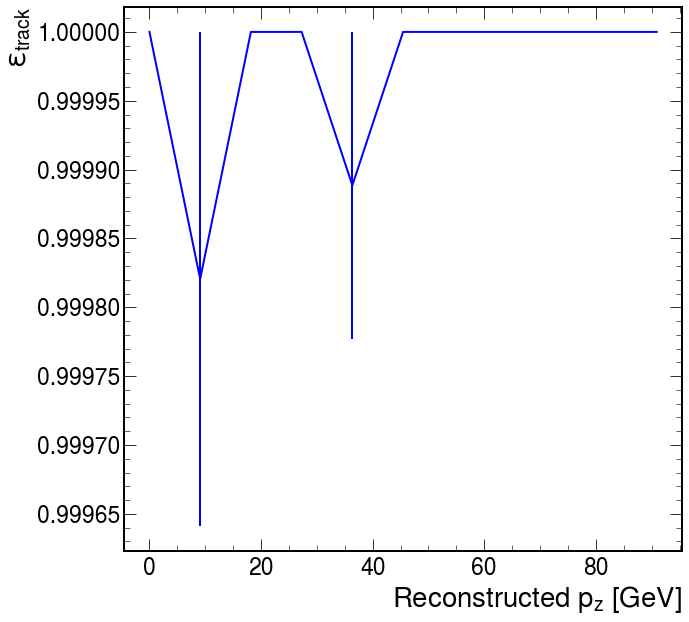

In [5]:
def plot_e_eff(dq_events, n_bins = 11):
    
    reco_select = ak.count(dq_events["RecoTracks"]["track_pz"], axis = 1) == 1
    
    pz = ak.flatten(dq_events["RecoTracks"]["track_pz"][reco_select])
    part_id = ak.flatten(dq_events["RecoTracks"]["track_ID"][reco_select])
    
    bin_means, bin_edges, binnumber = binned_statistic(pz, part_id == 13, statistic='mean',bins=n_bins,range=[0,100])
    bin_stds, bin_edges, binnumber = binned_statistic(pz, part_id == 13, statistic='std',bins=n_bins,range=[0,100])
    counts=[np.count_nonzero(binnumber==i) for i in np.arange(1,n_bins+1,1)]
    plt.errorbar(bin_edges[:n_bins], bin_means, bin_stds/np.sqrt(counts), color='b', lw=2, label='binned statistic of data')
    
    plt.xlabel('Reconstructed $p_z$ [GeV]')
    plt.ylabel('$\epsilon_{track}$')    
    

plot_e_eff(dq_events)